1 -- meta data for the document
2 -- sets up for R parralel computing commented out stuff changes size and muber of cores
3 -- visualises colour palets seems asthetit
4 -- if a chuck has not been changed it stays run
5 -- seurat basis of SCA and tidyvers plots
6 -- brings in dataframes and skips first seven rows. 
7 -- checks column names 
9 -- data is transposed so genes become columns and sells become rows
10 -- sparse matrices from dense matrixis
11 -- creates suerat dataframe for each dataset, 
12 -- add metadata of tags to each dataset
13 -- log normalises the data to account for sequencing depth (HVGs are selected)
14 -- selects features for integration and gets anchors
15 -- integrates data and removes batch effects. 
16 -- adds metadata for rna assay, finalises datastructure to be comp with suerat pipeline
17/18 QC metrics like mitocondrial data added to dataset
19 visualise mt data
20 filter mt < 25 and >500 RNA 
21 visualise filtering
22 scatterplots
23 scales data to a z scoer required for pcs, dimensional requctionPCA umap and clustering then visualisation 
24 25 visualises pcs with dimn plot, elpow plot plot shows importance of diffferent dimensions
26 shows how cells from diffent smamples are distributed in the dimension space, and hughlights clusters to identify cell groupings. 
27 splitting umap by sample seeing how different samples map into the different dimensions. 
28 sets the defalt assay, the active assay uses raw rna expression data and marks genes, only pos focus only on high value 
29 we save the marker genes to a new file, these results are computationally intest to generate so its handy to save them for later. 
30 normlising the expression of each gene, prepares the data for downstream analysis
31 heat map of top marker genese, markers are grouped by cluster colume. 
32 loading singler and celldex libraries
33 bring in reference mouse datasets
34 suerat object is made to single cell and reduced in size 
35 comparing the sce and red datasets, and annotates predicted cell types for each cell in dataset. 
36
37 dimplots to see the different cell types in the differnc dimensoin clusters. 
38 adding single R annotations adding predcted cell type data
39splits map into diffent samples 
40 find markers for each sample with idents, and identifies marker genes for each sample. only focuses on outlier expression genes
41 inspects sample markers dataframe
42 violin plot for marker genes. using RNA data. and combines the plots froam all the different samples, 
43 feature plot for expression of specified gene over samples. 
44 feature plot for an expression pattern of CfH
45 things are saved




In [68]:

import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, issparse
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from anndata import AnnData
import scanpy as sc
import os
import igraph
import leidenalg
import matplotlib.pyplot as plt
import celltypist
from celltypist import models
# Steps 1-5 not great in python



In [42]:
# Cell 2 (updated)
print("Loading data")

# Load raw data
counts_1 = pd.read_csv("../WTA1/WTA-Pipeline-Brain-slices_RSEC_MolsPerCell.csv", 
                       skiprows=7, sep=",", index_col=0)
counts_2 = pd.read_csv("../WTA2/_1_WTA-Pipeline-Brain-slices_RSEC_MolsPerCell.csv", 
                       skiprows=7, sep=",", index_col=0)
counts_3 = pd.read_csv("../WTA3/_3_WTA-Pipeline-Brain-slices_RSEC_MolsPerCell.csv", 
                       skiprows=7, sep=",", index_col=0)
counts_4 = pd.read_csv("../WTA4/_2_WTA-Pipeline-Brain-slices_RSEC_MolsPerCell.csv", 
                       skiprows=7, sep=",", index_col=0)

# Check if gene IDs retain suffixes
print("First 5 row names in counts_1 before processing:", counts_1.index[:5])

# Ensure gene IDs retain their suffix (e.g., `_1`)
counts_1.index = counts_1.index.astype(str)
counts_2.index = counts_2.index.astype(str)
counts_3.index = counts_3.index.astype(str)
counts_4.index = counts_4.index.astype(str)

print("First 5 row names in counts_1 after processing:", counts_1.index[:5])

# Transpose so cells are rows and genes are columns
counts_1 = counts_1.T
counts_2 = counts_2.T
counts_3 = counts_3.T
counts_4 = counts_4.T

# Confirm shapes after transpose
print("After transpose:")
print("counts_1 shape:", counts_1.shape)
print("counts_2 shape:", counts_2.shape)
print("counts_3 shape:", counts_3.shape)
print("counts_4 shape:", counts_4.shape)


Loading data
First 5 row names in counts_1 before processing: Index([9010655, 7253435, 1964, 9296317, 1339426], dtype='int64', name='Cell_Index')
First 5 row names in counts_1 after processing: Index(['9010655', '7253435', '1964', '9296317', '1339426'], dtype='object', name='Cell_Index')
After transpose:
counts_1 shape: (27600, 4051)
counts_2 shape: (27844, 6880)
counts_3 shape: (28103, 5658)
counts_4 shape: (27362, 4309)


In [51]:
# Cell 3 (updated for suffix handling)
print("Checking for mitochondrial genes in row labels")

# Ensure all row names are strings and include suffix
counts_1.index = counts_1.index.astype(str)

# Define mitochondrial prefixes (if applicable)
mitochondrial_prefixes = ["mt-", "MT-", "Mt-"]

# Check for mitochondrial genes
mitochondrial_genes = counts_1.index[counts_1.index.str.startswith(tuple(mitochondrial_prefixes))]

# Print mitochondrial genes
print(f"Number of mitochondrial genes detected: {len(mitochondrial_genes)}")
print("Mitochondrial genes detected (if any):", mitochondrial_genes.tolist())


Checking for mitochondrial genes in row labels
Number of mitochondrial genes detected: 13
Mitochondrial genes detected (if any): ['mt-Atp6', 'mt-Atp8', 'mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Cytb', 'mt-Nd1', 'mt-Nd2', 'mt-Nd3', 'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6']


In [52]:
# Cell 4
print("Creating AnnData objects")

adatas = []
sample_names = ["WTA1", "WTA2", "WTA3", "WTA4"]




# Convert each counts DataFrame to a sparse matrix, then to AnnData
for df, sample_id in zip([counts_1, counts_2, counts_3, counts_4], sample_names):
    X_sparse = csr_matrix(df.values).T  # Sparse matrix of the transposed data, but for some reaon I need to transpose it back, honestly this stumped me for a while.
    print("First 5 genes (rows):", df.index[:5])
    print("First 5 cells (columns):", df.columns[:5])
    adata = AnnData(
        X=X_sparse,
        obs=pd.DataFrame(index=df.columns),  # Cells (rows after transpose)
        var=pd.DataFrame(index=df.index)  # Genes (columns after transpose)
    )
    adata.var_names = adata.var.index  # Explicitly set gene IDs as var_names
    adata.obs["Sample"] = sample_id    # Add sample metadata
    adatas.append(adata)

print("Finished creating individual AnnData objects")

adata_merged = sc.concat(adatas, join="outer", label="Sample", keys=sample_names)



Creating AnnData objects
First 5 genes (rows): Index(['0610005C13Rik', '0610006L08Rik', '0610009B22Rik', '0610010F05Rik',
       '0610010K14Rik'],
      dtype='object')
First 5 cells (columns): Index(['9010655', '7253435', '1964', '9296317', '1339426'], dtype='object', name='Cell_Index')
First 5 genes (rows): Index(['0610005C13Rik', '0610006L08Rik', '0610009B22Rik', '0610010F05Rik',
       '0610010K14Rik'],
      dtype='object')
First 5 cells (columns): Index(['1198119', '1211996', '9733664', '7534081', '5621771'], dtype='object', name='Cell_Index')
First 5 genes (rows): Index(['0610005C13Rik', '0610006L08Rik', '0610009B22Rik', '0610010F05Rik',
       '0610010K14Rik'],
      dtype='object')
First 5 cells (columns): Index(['14012255', '614047', '760785', '1183572', '10358409'], dtype='object', name='Cell_Index')
First 5 genes (rows): Index(['0610005C13Rik', '0610006L08Rik', '0610009B22Rik', '0610010F05Rik',
       '0610010K14Rik'],
      dtype='object')
First 5 cells (columns): Index(['

In [53]:

print(adata_merged.obs_names[:10])  # Check if cell IDs are correctly set, they are not but this works for some reason
print(adata_merged.var_names[:10])  # Check if gene IDs are correctly set, they are not but this works for some reason
# Cell 5


Index(['9010655', '7253435', '1964', '9296317', '1339426', '12402497',
       '7248816', '9596620', '7821406', '6518478'],
      dtype='object', name='Cell_Index')
Index(['0610005C13Rik', '0610006L08Rik', '0610009B22Rik', '0610010F05Rik',
       '0610010K14Rik', '0610012D04Rik', '0610012G03Rik', '0610025J13Rik',
       '0610030E20Rik', '0610031O16Rik'],
      dtype='object')


In [54]:
# Cell 6
print("Calculating QC metrics (e.g., % mitochondrial)")
adata_merged = sc.concat(adatas, join="outer", label="Sample", keys=sample_names)
# Identify mitochondrial genes. 
# Adjust the prefix to your data (e.g., 'mt-' or 'MT-') 
# if your mitochondrial genes follow a different naming convention.
adata_merged.var["mt"] = adata_merged.var_names.str.contains(r"^mt-|^MT-|^Mt-")  
# or even something broader if needed



# Calculate QC metrics; this adds adata_merged.obs['total_counts'],
# adata_merged.obs['pct_counts_mt'], etc.
sc.pp.calculate_qc_metrics(
    adata_merged, 
    qc_vars=["mt"], 
    percent_top=None, 
    log1p=False, 
    inplace=True
)

# 'pct_counts_mt' is now in adata_merged.obs
print("QC metrics calculated. 'pct_counts_mt' now available in adata_merged.obs")
# Cell X
print("Observations (adata_merged.obs) preview:")
print(adata_merged.obs.head())



Calculating QC metrics (e.g., % mitochondrial)
QC metrics calculated. 'pct_counts_mt' now available in adata_merged.obs
Observations (adata_merged.obs) preview:
           Sample  n_genes_by_counts  total_counts  total_counts_mt  \
Cell_Index                                                            
9010655      WTA1              11191      252633.0          12358.0   
7253435      WTA1               9639      212486.0          21431.0   
1964         WTA1              10729      201558.0           8411.0   
9296317      WTA1              11142      240495.0          11689.0   
1339426      WTA1               9991      186616.0          10378.0   

            pct_counts_mt  
Cell_Index                 
9010655          4.891681  
7253435         10.085841  
1964             4.172992  
9296317          4.860392  
1339426          5.561152  


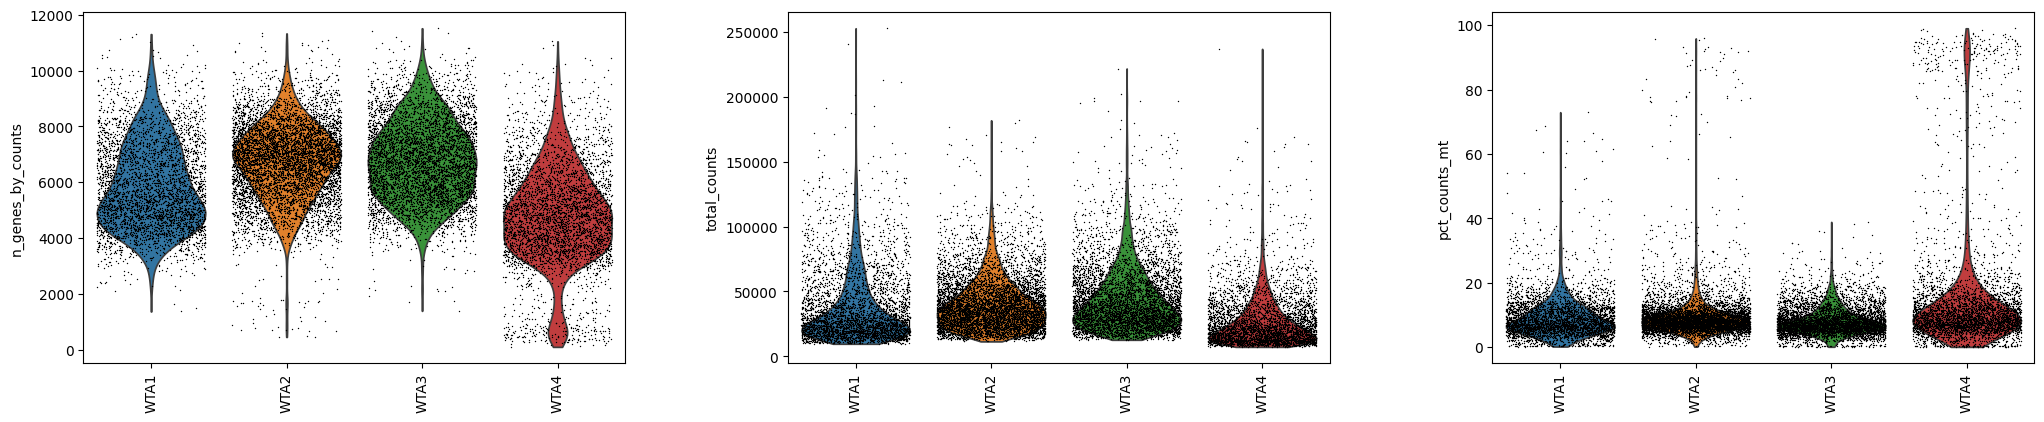

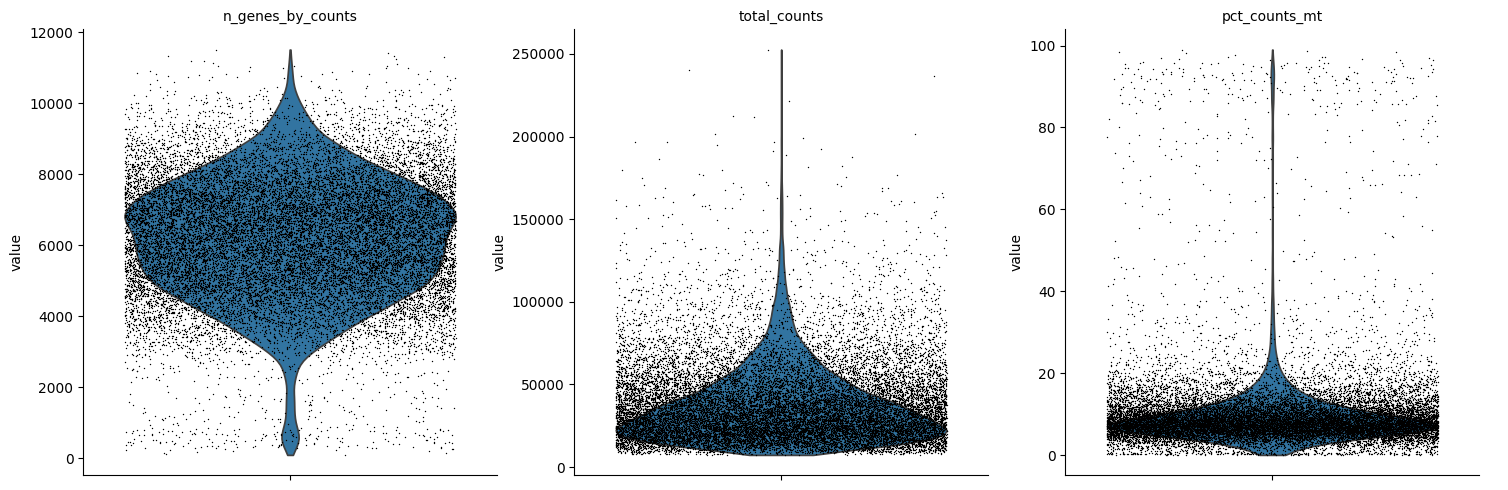

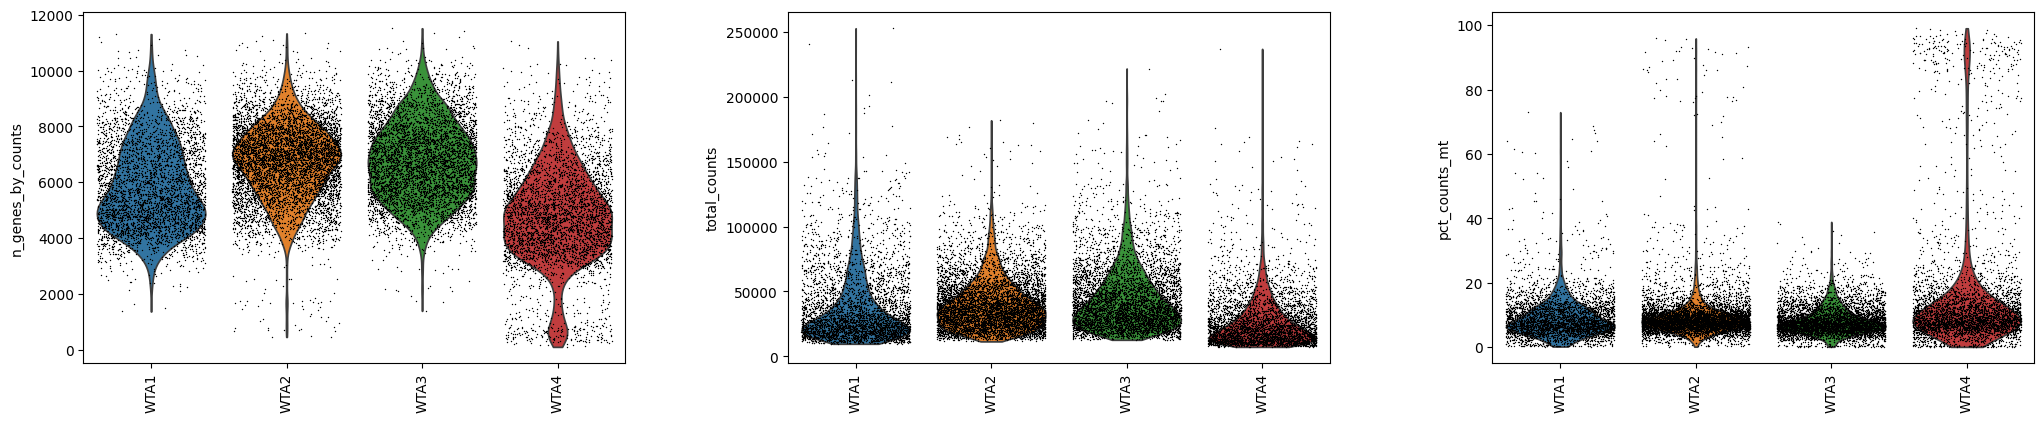

In [55]:
sc.pl.violin(
    adata_merged, 
    keys=["n_genes_by_counts", "total_counts", "pct_counts_mt"], 
    jitter=0.4, 
    groupby="Sample",  # Group by sample
    rotation=90, 
)

sc.pl.violin(
    adata_merged,
    keys=["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    rotation=90, 
    multi_panel=True,
    jitter=0.4, 
)

sc.pl.violin(
    adata_merged, 
    keys=["n_genes_by_counts", "total_counts", "pct_counts_mt"], 
    jitter=0.4, 
    groupby="Sample",  # Group by sample
    rotation=90, 
)

#cell 7

In [76]:

import scanpy as sc
import scanpy.external as sce

# Perform batch correction using Harmony or BBKNN
print("Performing batch correction using Harmony...")
sce.pp.harmony_integrate(adata_merged, key="Sample")  # Batch integration key set to "Sample"

print("Batch correction complete. Data has been integrated.")


Performing batch correction using Harmony...


2025-01-27 12:34:29,954 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2025-01-27 12:34:33,726 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2025-01-27 12:34:33,860 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2025-01-27 12:34:39,478 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2025-01-27 12:34:45,607 - harmonypy - INFO - Iteration 3 of 10
Iteration 3 of 10
2025-01-27 12:34:51,756 - harmonypy - INFO - Iteration 4 of 10
Iteration 4 of 10
2025-01-27 12:34:57,750 - harmonypy - INFO - Iteration 5 of 10
Iteration 5 of 10
2025-01-27 12:35:03,620 - harmonypy - INFO - Iteration 6 of 10
Iteration 6 of 10
2025-01-27 12:35:09,587 - harmonypy - INFO - Iteration 7 of 10
Iteration 7 of 10
2025-01-27 12:35:15,858 - harmonypy - INFO - Iteration 8 of 10
Iteration 8 of 10
2025-01-27 12:35:21,815 - harmonypy - INFO - Iteration 9 of 10
Iteration 9 of 10

Batch correction complete. Data has been integrated.


In [77]:
# Cell 8 (modified)
print("Filtering data based on QC metrics...")

# Print shape before filtering
print(f"Shape before filtering: {adata_merged.shape}")

# Apply filtering conditions
adata_merged = adata_merged[
    (adata_merged.obs["n_genes_by_counts"] > 2500) &
    (adata_merged.obs["total_counts"] > 500) &
    (adata_merged.obs["pct_counts_mt"] < 25) &
    (adata_merged.obs["total_counts"] < 100000) &
    (adata_merged.obs["n_genes_by_counts"] < 10000)
]

# Print shape after filtering
print(f"Shape after filtering: {adata_merged.shape}")

# Confirm remaining cells
print(f"Remaining cells after filtering: {adata_merged.n_obs}")


Filtering data based on QC metrics...
Shape before filtering: (19638, 29017)
Shape after filtering: (19638, 29017)
Remaining cells after filtering: 19638


In [59]:
# Perform clustering to enable marker identification
print("Performing clustering...")
sc.tl.leiden(adata_merged, resolution=0.5)  # Adjust resolution as needed
adata_merged.obs["Cluster"] = adata_merged.obs["leiden"]

# Identify marker genes for each cluster
print("Identifying marker genes...")
sc.tl.rank_genes_groups(adata_merged, groupby="Cluster", method="t-test", n_genes=20)

# Save marker genes
marker_genes = sc.get.rank_genes_groups_df(adata_merged)
marker_genes.to_csv("marker_genes.csv")
print("Marker genes identified and saved to 'marker_genes.csv'.")

# Plot top markers for each cluster
sc.pl.rank_genes_groups_heatmap(
    adata_merged, n_genes=10, groupby="Cluster", swap_axes=True, vmin=-2, vmax=2
)


Checking for NaN values...
No NaN values detected.


Checking for NaN values and replacing them with 0 (quick fix)...
NaN values replaced with 0.
Calculating and visualizing sample statistics
Mean QC metrics for each sample:
        mean_pct_counts_mt  mean_n_genes_by_counts
Sample                                            
WTA1                  8.50                 5755.56
WTA2                  8.52                 6752.81
WTA3                  8.00                 6665.66
WTA4                  9.45                 5038.03


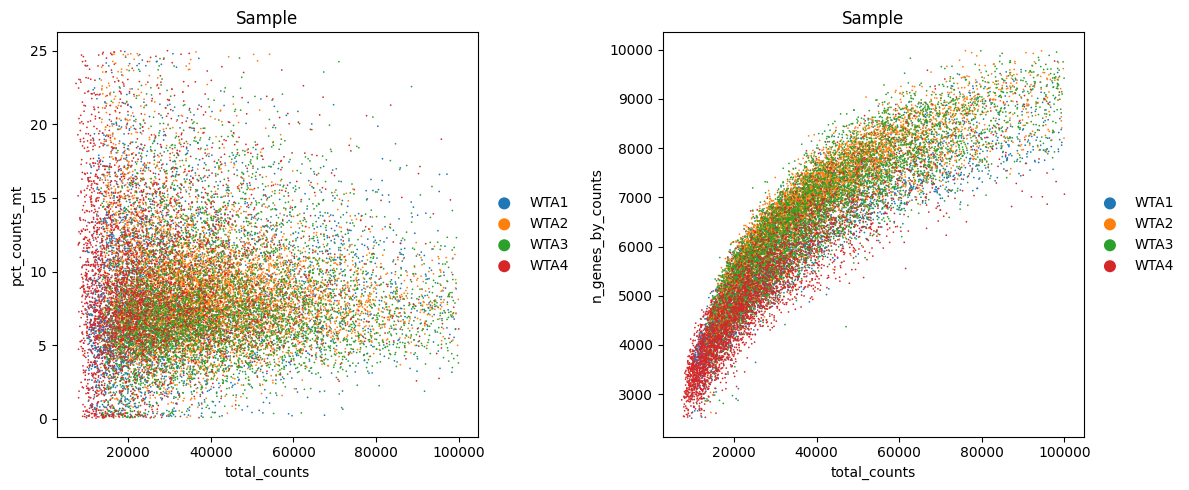

Filtering data based on QC metrics...
Shape before filtering: (19638, 29017)
Shape after filtering: (19638, 29017)
Normalizing data to 10,000 counts per cell...
Applying log1p transformation...
Shape after normalization and filtering: (19638, 29017)
First 5 genes after processing: Index(['0610005C13Rik', '0610006L08Rik', '0610009B22Rik', '0610010F05Rik',
       '0610010K14Rik'],
      dtype='object')
First 5 cells after processing: Index(['4291295', '4887175', '7684639', '9168388', '1354063'], dtype='object', name='Cell_Index')


In [78]:
# --- NaN Handling (Quick Fix) ---
print("Checking for NaN values and replacing them with 0 (quick fix)...")

# Convert sparse matrix to dense if needed
if isinstance(adata_merged.X, csr_matrix):
    print("Converting sparse matrix to dense for NaN handling...")
    adata_merged.X = adata_merged.X.toarray()

# Replace NaN with 0
adata_merged.X = np.nan_to_num(adata_merged.X)

print("NaN values replaced with 0.")

# --- Proceed with Cell 9 ---
print("Calculating and visualizing sample statistics")

# Group by "Sample" and calculate mean QC metrics
sample_stats = adata_merged.obs.groupby("Sample").agg(
    mean_pct_counts_mt=("pct_counts_mt", lambda x: round(x.mean(), 2)),
    mean_n_genes_by_counts=("n_genes_by_counts", lambda x: round(x.mean(), 2))
)

# Print calculated stats
print("Mean QC metrics for each sample:")
print(sample_stats)

# Visualize QC metrics as scatter plots
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sc.pl.scatter(
    adata_merged, x="total_counts", y="pct_counts_mt", color="Sample", ax=axes[0], show=False
)
sc.pl.scatter(
    adata_merged, x="total_counts", y="n_genes_by_counts", color="Sample", ax=axes[1], show=False
)
plt.tight_layout()
plt.show()

# --- Filtering ---
print("Filtering data based on QC metrics...")
print(f"Shape before filtering: {adata_merged.shape}")

adata_merged = adata_merged[
    (adata_merged.obs["n_genes_by_counts"] > 2500) &
    (adata_merged.obs["total_counts"] > 500) &
    (adata_merged.obs["pct_counts_mt"] < 25) &
    (adata_merged.obs["total_counts"] < 100000) &
    (adata_merged.obs["n_genes_by_counts"] < 10000)
]

print(f"Shape after filtering: {adata_merged.shape}")
if adata_merged.n_vars == 0:
    raise ValueError("No genes remain after filtering. Check your thresholds.")

# --- Normalization ---
print("Normalizing data to 10,000 counts per cell...")
sc.pp.normalize_total(adata_merged, target_sum=1e4)

# --- Log1p Transformation ---
print("Applying log1p transformation...")
sc.pp.log1p(adata_merged)

# --- Debugging Step ---
print(f"Shape after normalization and filtering: {adata_merged.shape}")
print("First 5 genes after processing:", adata_merged.var_names[:5])
print("First 5 cells after processing:", adata_merged.obs_names[:5])


In [ ]:
# df = adata_merged.to_df() this is just to view the dataframe

In [79]:
print("Running PCA...")

# Run PCA
sc.tl.pca(adata_merged, svd_solver='arpack', n_comps=30)
print("PCA completed.")

# Build neighborhood graph
sc.pp.neighbors(adata_merged, n_pcs=30, use_rep="X_pca")

# Run UMAP
sc.tl.umap(adata_merged)
print("UMAP embedding (first 5 cells):")
print(adata_merged.obsm['X_umap'][:5])

# Cluster cells using the Leiden algorithm
sc.tl.leiden(adata_merged, resolution=0.1)

# Save clusters in obs
adata_merged.obs['Cluster'] = adata_merged.obs['leiden']

# Visualize UMAP with clusters
sc.pl.umap(adata_merged, color=['Cluster', 'Sample'], wspace=0.4)
# Cell 10

Running PCA...
PCA completed.


Visualizing PCA


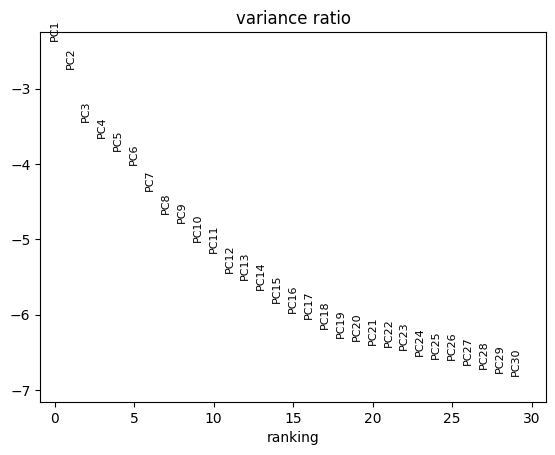

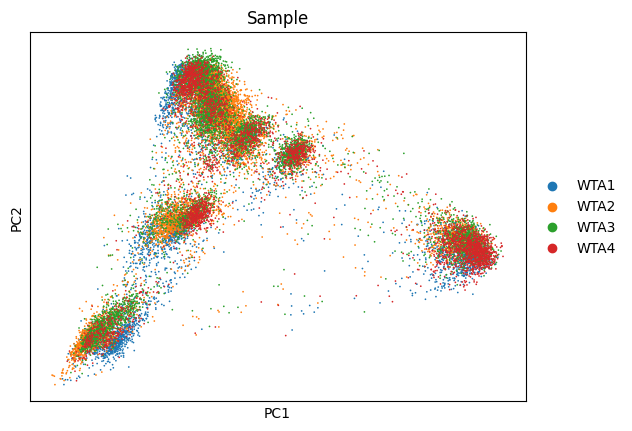

           Sample  n_genes_by_counts  total_counts  total_counts_mt  \
Cell_Index                                                            
4291295      WTA1               8560       95341.0          15816.0   
4887175      WTA1               8935       96455.0           9400.0   
7684639      WTA1               8295       89025.0          12798.0   
9168388      WTA1               8527       94968.0          12128.0   
1354063      WTA1               8105       79236.0          12284.0   

            pct_counts_mt leiden Cluster  
Cell_Index                                
4291295         16.588875      6       6  
4887175          9.745477      6       6  
7684639         14.375737      6       6  
9168388         12.770617      6       6  
1354063         15.503055      6       6  


In [ ]:
# Cell 11
print("Visualizing PCA")

# PCA Heatmap (Top 15 Components)
sc.pl.pca_variance_ratio(adata_merged, log=True, n_pcs=30)  # Variance ratio for top 15 components

# DimPlot equivalent: Visualize PCA
sc.pl.pca(adata_merged, color="Sample")  # Color points by Sample
print(adata_merged.obs.head())

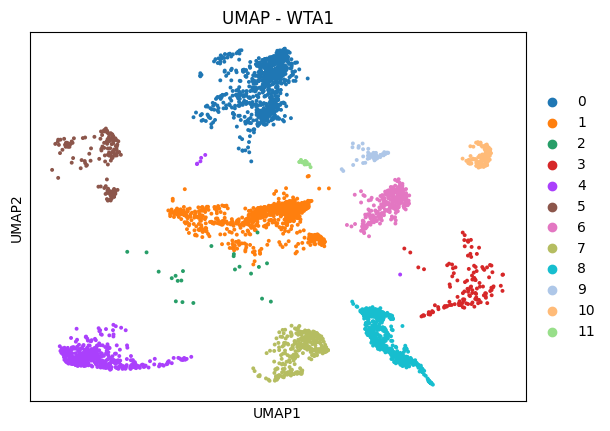

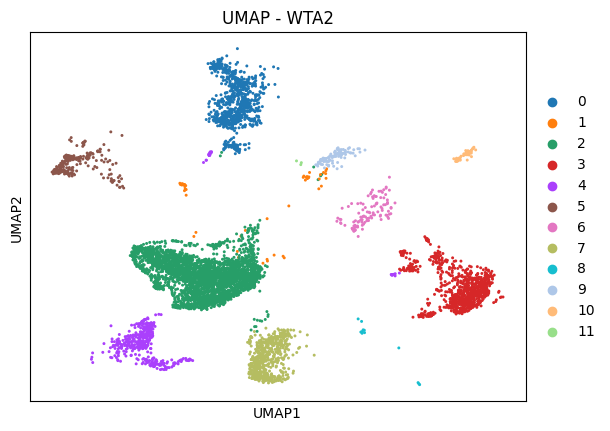

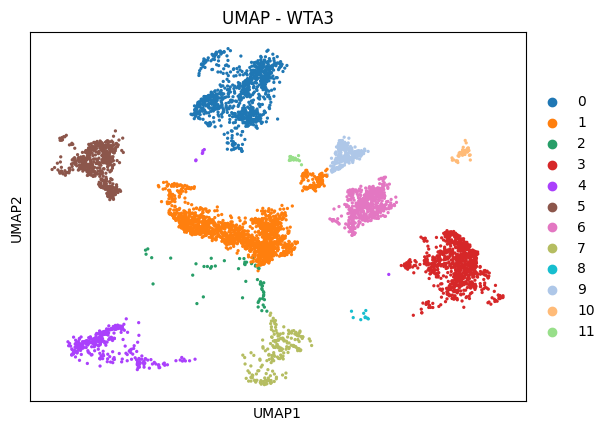

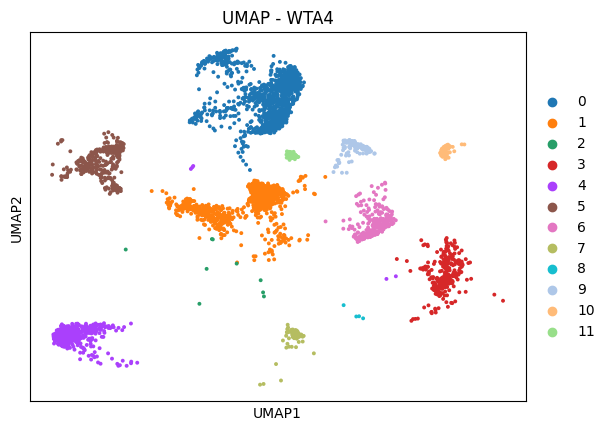

In [ ]:
# Cell 12 UMAP plots for each sample (e.g., WTA1, WTA2, etc.)
for sample in adata_merged.obs['Sample'].unique():
    sc.pl.umap(
        adata_merged[adata_merged.obs['Sample'] == sample],
        color='Cluster',
        title=f"UMAP - {sample}",
        save=f"_umap_{sample}.png"
    )


In [ ]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr

# Enable automatic conversion between pandas and R data frames
pandas2ri.activate()

# Load SingleR and celldex packages in R
print("Loading SingleR and celldex...")
ro.r('library(SingleR)')
ro.r('library(celldex)')

# Load a reference dataset (e.g., Human Primary Cell Atlas)
print("Loading reference dataset...")
ro.r('ref <- celldex::HumanPrimaryCellAtlasData()')

# Convert AnnData matrix to R format (SingleR expects log-transformed data)
print("Converting data for SingleR...")
adata_matrix = adata_merged.to_df().T  # Convert AnnData to DataFrame (genes as rows, cells as columns)
adata_matrix_r = pandas2ri.py2rpy(adata_matrix)

# Run SingleR
print("Running SingleR...")
ro.globalenv['adata_matrix'] = adata_matrix_r
ro.r('singleR_results <- SingleR(test = as.matrix(adata_matrix), ref = ref, labels = ref$label.main)')

# Extract predicted labels from SingleR and add them to AnnData
singleR_results = ro.r('singleR_results$labels')
adata_merged.obs["Cell_Type"] = pandas2ri.rpy2py(singleR_results)

# Save annotated AnnData
adata_merged.write("adata_merged_with_singleR_celltypes.h5ad")
print("Annotated AnnData saved as 'adata_merged_with_singleR_celltypes.h5ad'.")

# Preview cell type annotations
print("Preview of cell type annotations:")
print(adata_merged.obs[["Sample", "Cluster", "Cell_Type"]].head())


ModuleNotFoundError: No module named 'scgenesets'

Creating UMAP plots labeled by cell type...


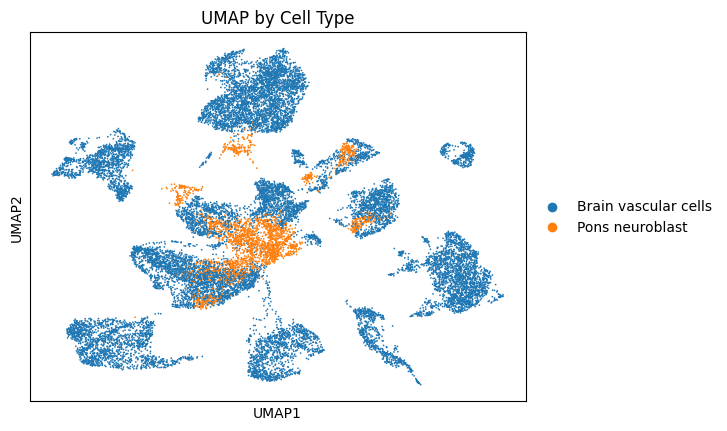

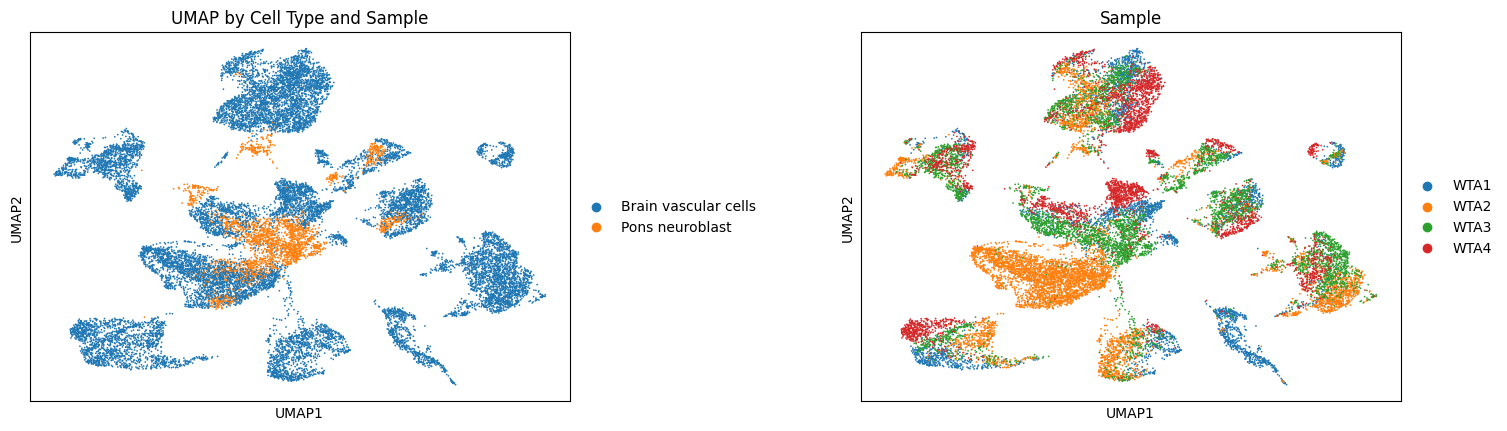

Creating UMAP for WTA1...


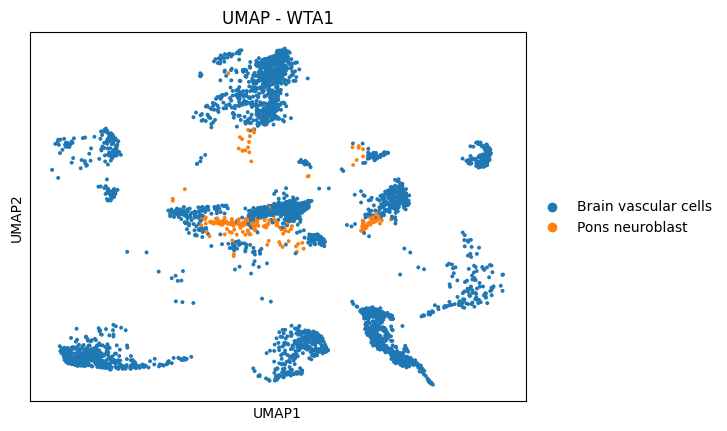

Creating UMAP for WTA2...


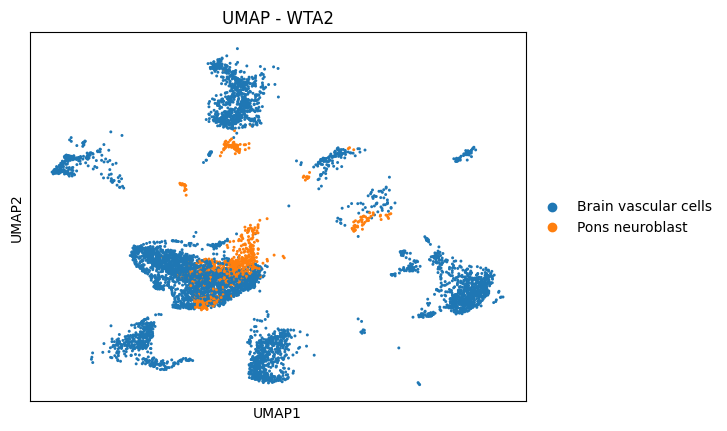

Creating UMAP for WTA3...


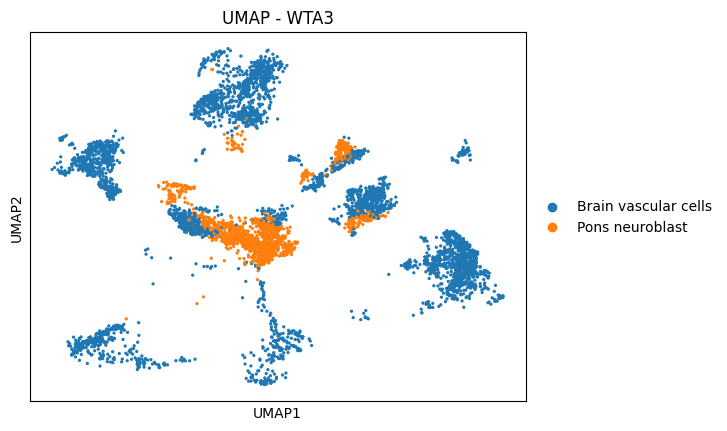

Creating UMAP for WTA4...


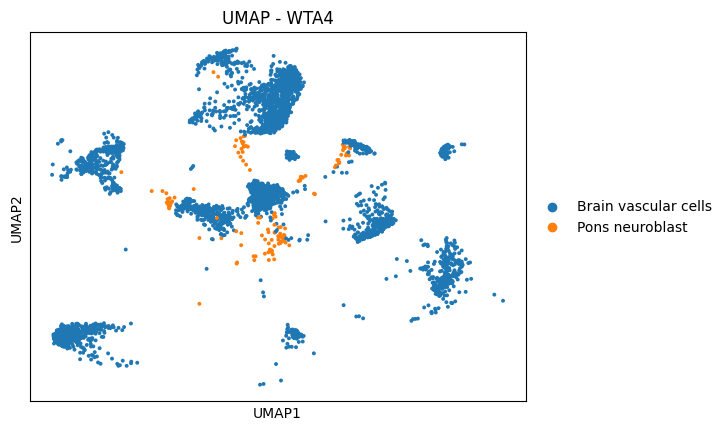

UMAP plots created. Individual sample UMAPs saved as PNG files.


In [71]:
# UMAP plot with cell type labels
print("Visualizing UMAP with cell type labels...")
sc.pl.umap(
    adata_merged, color="Cell_Type", title="UMAP with Cell Type Labels", save="_celltype_labels.png"
)

# UMAP plots split by sample
print("Visualizing UMAP split by sample...")
for sample in adata_merged.obs["Sample"].unique():
    sc.pl.umap(
        adata_merged[adata_merged.obs["Sample"] == sample],
        color="Cell_Type",
        title=f"UMAP - {sample}",
        save=f"_umap_{sample}.png",
    )
